In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Сверточный классификатор

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [3]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [4]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [6]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [259]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [9]:
for epoch in range(1, 6):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.334873 drop: 2.311761 plain: 2.416324
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.599786 drop: 2.253293 plain: 2.257719
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.100063 drop: 2.180715 plain: 2.203662
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 0.761588 drop: 1.767864 plain: 1.837004
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.586572 drop: 1.328653 plain: 1.350680
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.450481 drop: 0.945651 plain: 0.952827
Test set:
bn: Loss: 0.4996	Accuracy: 9239.0/10000 (92%)
drop: Loss: 0.9922	Accuracy: 8142.0/10000 (81%)
plain: Loss: 0.9925	Accuracy: 8098.0/10000 (81%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.414336 drop: 0.910160 plain: 0.901971
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.436879 drop: 0.827083 plain: 0.834021
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.423492 drop: 0.766547 plain: 0.765066
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.277902 drop: 0.530505 plain: 0.52

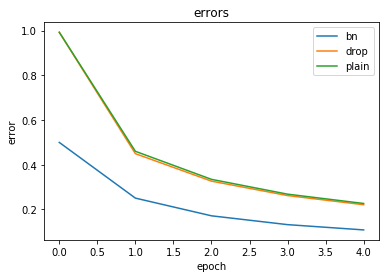

In [10]:
plot_graphs(test_log, 'loss')

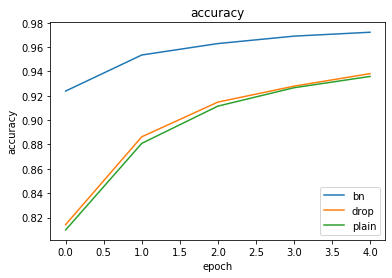

In [11]:
plot_graphs(test_log, 'accuracy')

# Оптимизация изображения под активацию сверточных нейронов классификатора

img shape torch.Size([1, 1, 28, 28])


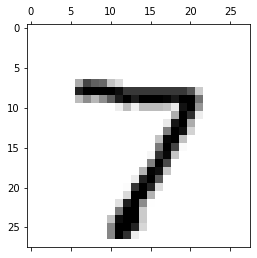

In [286]:
X_test, y_test = next(iter(test_loader))
img = X_test[:1]
img_ = img.view(-1, 28*28)
print('img shape', img.shape)
plt.matshow(img[0, 0, :, :],  cmap = matplotlib.cm.binary)

Conv1 shape torch.Size([1, 16, 14, 14])


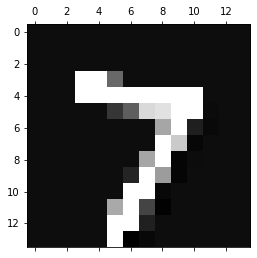

In [287]:
conv1_output = models['bn']._conv1(img)
print('Conv1 shape', conv1_output.shape)
plt.matshow(conv1_output.detach().numpy()[0, 0, :, :],  cmap = matplotlib.cm.binary)

Conv2 shape torch.Size([1, 32, 7, 7])


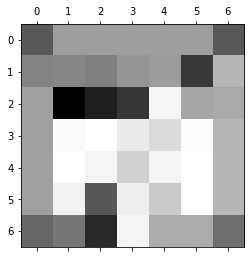

In [290]:
conv2_output = models['bn']._conv2(conv1_output)
print('Conv2 shape', conv2_output.shape)
plt.matshow(conv2_output.detach().numpy()[0, 0, :, :],  cmap = matplotlib.cm.binary)

FC shape torch.Size([1, 10])
Result tensor(7.4055, grad_fn=<MaxBackward1>)


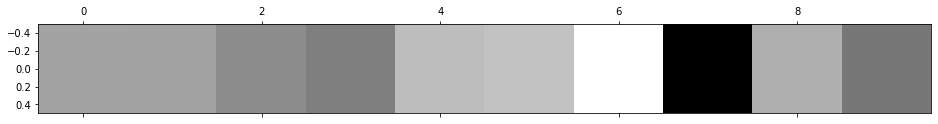

In [293]:
fc_output = models['bn'].fc(conv2_output.view(-1, 32*7*7))
print('FC shape', fc_output.shape)
print('Result', fc_output.max())
plt.matshow(fc_output.detach().numpy(), cmap = matplotlib.cm.binary)

Conv1


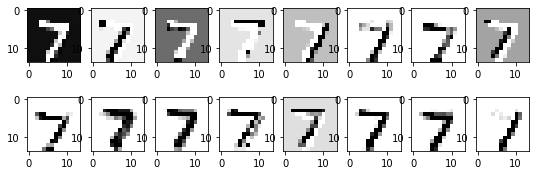

In [298]:
images_per_row = 8
n_features = models['bn']._conv1.model[0].weight.shape[0]
size = models['bn']._conv1.model[0].weight.shape[-1]
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))

print('Conv1')
fig = plt.figure(figsize=(9, 3))
for channel in range(16):
    channel_image = conv1_output[:, channel, :, :]
    channel_image -= channel_image.mean()
    channel_image /= channel_image.std()
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image.detach().numpy(), 0, 255).astype('uint8')
    plt.subplot(2, 8, channel+1)
    plt.imshow(channel_image[0, :, :], cmap = matplotlib.cm.binary)

Conv2


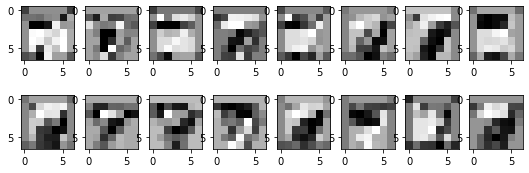

In [299]:
print('Conv2')
fig = plt.figure(figsize=(9, 3))
for channel in range(16):
    channel_image = conv2_output[:, channel, :, :]
    channel_image -= channel_image.mean()
    channel_image /= channel_image.std()
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image.detach().numpy(), 0, 255).astype('uint8')
    plt.subplot(2, 8, channel+1)
    plt.imshow(channel_image[0, :, :], cmap = matplotlib.cm.binary)

FC


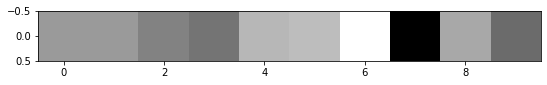

In [300]:
print('FC')
fig = plt.figure(figsize=(9, 3))
channel_image = fc_output
channel_image -= channel_image.mean()
channel_image /= channel_image.std()
channel_image *= 64
channel_image += 128
channel_image = np.clip(channel_image.detach().numpy(), 0, 255).astype('uint8')
plt.imshow(channel_image, cmap = matplotlib.cm.binary)